# House Prices: Advanced Regression Techniques

In [13]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv('data/train.csv')
train = train.set_index('Id')
test = pd.read_csv('data/test.csv')

numeric_features = train.select_dtypes(include=[np.number])
categoricals = train.select_dtypes(exclude=[np.number])

# Process Training Data
Handle missingness and encode categorical variables

### Missingness

In [17]:
missingCols = train.isnull().any(axis=0)
nulls = pd.DataFrame(train[train.columns[missingCols]].isnull().sum().sort_values(ascending=False))
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
Electrical,1


In [15]:
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean()) # unclear why NA 
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean()) # better than other options
train['MasVnrArea'] = train['MasVnrArea'].fillna(0) # NA is from no masonry veneer area

In [16]:
train['PoolQC'] = train['PoolQC'].fillna('No Pool')
train['MiscFeature'] = train['MiscFeature'].fillna('None')
train['Alley'] = train['Alley'].fillna('No alley access')
train['Fence'] = train['Fence'].fillna('No Fence')
train['FireplaceQu'] = train['FireplaceQu'].fillna('No Fireplace')
train['GarageCond'] = train['GarageCond'].fillna('No Garage')
train['GarageQual'] = train['GarageQual'].fillna('No Garage')
train['GarageFinish'] = train['GarageFinish'].fillna('No Garage')
train['GarageType'] = train['GarageType'].fillna('No Garage')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('No Basement')
train['BsmtExposure'] = train['BsmtExposure'].fillna('No Basement')
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('No Basement')
train['BsmtCond'] = train['BsmtCond'].fillna('No Basement')
train['BsmtQual'] = train['BsmtQual'].fillna('No Basement')
train['MasVnrType'] = train['MasVnrType'].fillna('None')

In [18]:
#drop missing electrical row
missingRows = train.isnull().any(axis=1)
train = train[-missingRows]

### Encode Categorical Variables

Tree-Based models work easily with encoded categorical variables because the distance between integers does not impact how the model is built. Here we will encode the categorical variables instead of dummifying them.

In [19]:
# Features for LR use only:
encoded_features = train.iloc[:, 0:79].copy()
# Binary Categorical Variables can be changed to 0 or 1:
encoded_features['Street'] = encoded_features['Street'].apply(lambda x: 0 if x == 'Pave' else 1)
encoded_features['Utilities'] = encoded_features['Utilities'].apply(lambda x: 0 if x == 'AllPub' else 1)
encoded_features['CentralAir'] = encoded_features['CentralAir'].apply(lambda x: 0 if x == 'N' else 1)

# MSSubClass refers to categories, but is currently an integer type. Since we are encoding the categorical variables 
# for tree-based models, we can keep this variable as is.

# dummified_features['MSSubClass'] = dummified_features['MSSubClass'].astype(str)

In [20]:
categoricals = encoded_features.select_dtypes(exclude=[np.number])
categoricals.columns

Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [35]:
lencoder = LabelEncoder()
print(encoded_features.shape)
for variable in categoricals.columns:
    encoded_features[variable] = lencoder.fit_transform(encoded_features[variable]).reshape((-1,1))
print(encoded_features.shape)

(1459, 79)
(1459, 79)


In [37]:
encoded_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,3,65.0,8450,0,1,3,3,0,4,...,0,0,3,4,1,0,2,2008,8,4
2,20,3,80.0,9600,0,1,3,3,0,2,...,0,0,3,4,1,0,5,2007,8,4
3,60,3,68.0,11250,0,1,0,3,0,4,...,0,0,3,4,1,0,9,2008,8,4
4,70,3,60.0,9550,0,1,0,3,0,0,...,0,0,3,4,1,0,2,2006,8,0
5,60,3,84.0,14260,0,1,0,3,0,2,...,0,0,3,4,1,0,12,2008,8,4


# Process Test Data:

### Missingness

In [43]:
missingCols = test.isnull().any(axis=0)
nulls = pd.DataFrame(test[test.columns[missingCols]].isnull().sum().sort_values(ascending=False))
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1456
MiscFeature,1408
Alley,1352
Fence,1169
FireplaceQu,730
LotFrontage,227
GarageYrBlt,78
GarageCond,78
GarageQual,78


In [44]:
numeric_test = test.select_dtypes(include=[np.number])
numeric_test.columns[numeric_test.isnull().any(axis=0)]

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [45]:
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].mean())
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(test['BsmtFinSF1'].mean())
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(test['BsmtFinSF2'].mean())
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(test['BsmtUnfSF'].mean())
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mean())
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(test['BsmtFullBath'].mean())
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(test['BsmtHalfBath'].mean())
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['GarageYrBlt'].mean())
test['GarageCars'] = test['GarageCars'].fillna(test['GarageCars'].mean())
test['GarageArea'] = test['GarageArea'].fillna(test['GarageArea'].mean())

In [46]:
test['PoolQC'] = test['PoolQC'].fillna('No Pool')
test['MiscFeature'] = test['MiscFeature'].fillna('None')
test['Alley'] = test['Alley'].fillna('No alley access')
test['Fence'] = test['Fence'].fillna('No Fence')
test['FireplaceQu'] = test['FireplaceQu'].fillna('No Fireplace')
test['GarageFinish'] = test['GarageFinish'].fillna('No Garage')
test['GarageType'] = test['GarageType'].fillna('No Garage')
test['BsmtExposure'] = test['BsmtExposure'].fillna('No Basement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('No Basement')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('No Basement')
test['MasVnrType'] = test['MasVnrType'].fillna('None')
test['Utilities'] = test['Utilities'].fillna(test['Utilities'].mode()[0])
test['Functional'] = test['Functional'].fillna(test['Functional'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])

test['GarageCond'] = test['GarageCond'].fillna('No Garage')
test['GarageQual'] = test['GarageQual'].fillna('No Garage')
test['BsmtCond'] = test['BsmtCond'].fillna('No Basement')
test['BsmtQual'] = test['BsmtQual'].fillna('No Basement')
test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])

### Encode Categorical Variables

In [47]:
encoded_test_features = test.iloc[:, 0:79].copy()
# Binary Categorical Variables can be changed to 0 or 1:
encoded_test_features['Street'] = encoded_test_features['Street'].apply(lambda x: 0 if x == 'Pave' else 1)
encoded_test_features['Utilities'] = encoded_test_features['Utilities'].apply(lambda x: 0 if x == 'AllPub' else 1)
encoded_test_features['CentralAir'] = encoded_test_features['CentralAir'].apply(lambda x: 0 if x == 'N' else 1)

In [48]:
test_categoricals = encoded_test_features.select_dtypes(exclude=[np.number])
test_categoricals.columns

Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

In [49]:
lencoder = LabelEncoder()
print(encoded_test_features.shape)
for variable in test_categoricals.columns:
    encoded_test_features[variable] = lencoder.fit_transform(encoded_test_features[variable]).reshape((-1,1))
print(encoded_test_features.shape)

(1459, 79)
(1459, 79)


In [50]:
encoded_test_features.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType
0,1461,20,2,80.0,11622,0,1,3,3,0,...,0,120,0,2,2,1,0,6,2010,8
1,1462,20,3,81.0,14267,0,1,0,3,0,...,0,0,0,2,4,0,12500,6,2010,8
2,1463,60,3,74.0,13830,0,1,0,3,0,...,0,0,0,2,2,1,0,3,2010,8
3,1464,60,3,78.0,9978,0,1,0,3,0,...,0,0,0,2,4,1,0,6,2010,8
4,1465,120,3,43.0,5005,0,1,0,1,0,...,0,144,0,2,4,1,0,1,2010,8


# Tree Based Models

## Decision Tree

In [80]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
tree_model = tree.DecisionTreeRegressor()

y = train.SalePrice

X_train, X_test, y_train, y_test = train_test_split(encoded_features,y,test_size=0.3)

In [60]:
scoring = make_scorer(mean_squared_error)
grid_para_tree = [{
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_model.set_params(random_state=108)
grid_search_tree = GridSearchCV(tree_model, grid_para_tree, cv=5, scoring='r2', n_jobs=-1)
%time grid_search_tree.fit(X_train, y_train)

Wall time: 4.3 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=108, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'min_samples_leaf': range(1, 10), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [61]:
grid_search_tree.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 24}

In [62]:
grid_search_tree.best_score_

0.7546520494947787

In [63]:
grid_search_tree.score(X_train, y_train)

0.9139918276118325

In [64]:
grid_search_tree.score(X_test, y_test)

0.8208145399855129

## Random Forest Model

In [83]:
from sklearn import ensemble

randomForest = ensemble.RandomForestRegressor()
randomForest.fit(X_train, y_train) 

print("The training error is: %.5f" % (1-randomForest.score(X_train, y_train)))
print("The test     error is: %.5f" % (1-randomForest.score(X_test, y_test)))

The training error is: 0.03516
The test     error is: 0.18338


D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [82]:
grid_para_forest = {
    'max_depth': range(1, 31),
    'n_estimators': range(10, 100, 10),
}
grid_search_forest = GridSearchCV(randomForest, grid_para_forest, scoring='r2', cv=5, n_jobs=-1)
%time grid_search_forest.fit(X_train, y_train)

Wall time: 3min 53s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(1, 31), 'n_estimators': range(10, 100, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [84]:
grid_search_forest.best_params_

{'max_depth': 11, 'n_estimators': 30}

In [85]:
print("The training error is: %.5f" % (grid_search_forest.score(X_train, y_train)))
print("The test     error is: %.5f" % (grid_search_forest.score(X_test, y_test)))

The training error is: 0.97636
The test     error is: 0.82331


In [86]:
randomForest.set_params(max_depth=11, n_estimators=30)
grid_para_forest = {
    'min_samples_leaf': range(1, 20),
    'min_samples_split': np.linspace(start=2, stop=30, num=15, dtype=int)
}
grid_search_forest = GridSearchCV(randomForest, grid_para_forest, scoring='r2', cv=5, n_jobs=-1)
%time grid_search_forest.fit(X_train, y_train)

Wall time: 1min 54s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_leaf': range(1, 20), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [87]:
grid_search_forest.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 4}

In [88]:
grid_search_forest.best_score_

0.8531186690620621

In [89]:
print("The training error is: %.5f" % (grid_search_forest.score(X_train, y_train)))
print("The test     error is: %.5f" % (grid_search_forest.score(X_test, y_test)))

The training error is: 0.96014
The test     error is: 0.82415


## Gradient Boosting

In [118]:
from sklearn.ensemble import GradientBoostingRegressor
gbmr = GradientBoostingRegressor()
gbmr.fit(encoded_features, y)
gbmr.score(encoded_features, y)
gbmr.get_params()

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(encoded_features, y, test_size=0.3)
gbmr.fit(X_train,Y_train)
print('-'*50)
print("The train set R^2 is %.3f" %(gbmr.score(X_train, Y_train)))
print("The test set R^2 is %.3f" %(gbmr.score(X_test,Y_test)))

--------------------------------------------------
The train set R^2 is 0.970
The test set R^2 is 0.868


### Learning Rate

In [95]:
from sklearn.metrics import r2_score 
n_estimators = 50100
steps = range(100, 50100, 1000)

gbmr.set_params(learning_rate = 1, n_estimators=n_estimators, max_depth=3)
gbmr.fit(X_train, Y_train)
gen = gbmr.staged_predict(X_train)
r2_rate1 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_rate1.append(r2_score(Y_train, predicted_targets))

In [96]:
gbmr.set_params(learning_rate = 0.1)
gbmr.fit(X_train, Y_train)
gen = gbmr.staged_predict(X_train)
r2_rate01 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_rate01.append(r2_score(Y_train, predicted_targets)) 

In [99]:
gbmr.set_params(learning_rate = 0.001)
gbmr.fit(X_train, Y_train)
gen = gbmr.staged_predict(X_train)
r2_rate001 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_rate001.append(r2_score(Y_train, predicted_targets))    

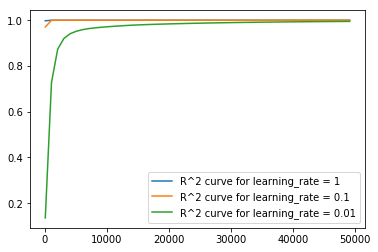

In [100]:
plt.plot(steps, r2_rate1,  label=r'R^2 curve for learning_rate = 1')
plt.plot(steps, r2_rate01, label=r'R^2 curve for learning_rate = 0.1')
plt.plot(steps, r2_rate001, label=r'R^2 curve for learning_rate = 0.01')
plt.legend(loc=4)

### Max Depth

In [101]:
gbmr.set_params(learning_rate = 0.0001, max_depth = 3)
    
gbmr.fit(X_train, Y_train)
gen = gbmr.staged_predict(X_train)
r2_maxdepth3 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_maxdepth3.append(r2_score(Y_train, predicted_targets)) 

In [102]:
gbmr.set_params(learning_rate = 0.0001, max_depth = 5)
    
gbmr.fit(X_train, Y_train)
gen = gbmr.staged_predict(X_train)
r2_maxdepth5 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_maxdepth5.append(r2_score(Y_train, predicted_targets)) 

In [103]:
gbmr.set_params(learning_rate = 0.0001, max_depth = 10)
    
gbmr.fit(X_train, Y_train)
gen = gbmr.staged_predict(X_train)
r2_maxdepth10 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_maxdepth10.append(r2_score(Y_train, predicted_targets))   

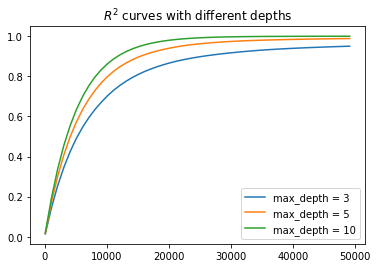

In [104]:
plt.plot(steps, r2_maxdepth3, label='max_depth = 3')
plt.plot(steps, r2_maxdepth5, label='max_depth = 5')
plt.plot(steps, r2_maxdepth10, label='max_depth = 10')
plt.title('$R^2$ curves with different depths')
plt.legend(loc=4)

In [117]:
gbmr.set_params(learning_rate = 0.0001, max_depth = 5, n_estimators = 2000)
gbmr.fit(X_train, Y_train)
gbmr.score(X_train, Y_train)

0.2910327777597227

In [116]:
gbmr.score(X_test, Y_test)

0.7958707025880164

In [ ]:
- comparing learning rate and max depth scores as n_estimators increase
- also can compare how subsampling improves score
- grid search to minimize the overfit
- feature importance

In [160]:
gbmr = GradientBoostingRegressor()
X_train, X_test, Y_train, Y_test = train_test_split(encoded_features, y, test_size=0.3)
gbmr.fit(X_train,Y_train)
print('-'*50)
print("The train set R^2 is %.3f" %(gbmr.score(X_train, Y_train)))
print("The test set R^2 is %.3f" %(gbmr.score(X_test,Y_test)))

--------------------------------------------------
The train set R^2 is 0.972
The test set R^2 is 0.817


In [161]:
gbmr.get_params()

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [189]:
gbmr.set_params(learning_rate =  0.01)
grid_para_forest = {
#    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
    'n_estimators': range(10, 3000, 100),
}
grid_search_boosting = GridSearchCV(gbmr, grid_para_forest, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
%time grid_search_boosting.fit(X_train, Y_train)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 1min 32s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samp...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': range(10, 3000, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [190]:
grid_search_boosting.best_params_

{'n_estimators': 2610}

In [179]:
grid_search_boosting.best_model

AttributeError: 'GridSearchCV' object has no attribute 'best_model'

In [192]:
print("The train set R^2 is %.3f" %(-grid_search_boosting.score(X_train, Y_train)))
print("The test set R^2 is %.3f" %(-grid_search_boosting.score(X_test,Y_test)))

The train set R^2 is 67409967.898
The test set R^2 is 1255061571.071


In [197]:
gbmr.set_params(learning_rate = 0.01, n_estimators = 2610)
grid_para_forest = {
    'max_depth': range(1, 10),
    'subsample': [1.0, 0.9, 0.5]
}
grid_search_boosting = GridSearchCV(gbmr, grid_para_forest, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
%time grid_search_boosting.fit(X_train, Y_train)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 5min 53s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samp...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(1, 10), 'subsample': [1.0, 0.9, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [198]:
grid_search_boosting.best_params_

{'max_depth': 4, 'subsample': 0.5}

In [199]:
print("The train set R^2 is %.3f" %(-grid_search_boosting.score(X_train, Y_train)))
print("The test set R^2 is %.3f" %(-grid_search_boosting.score(X_test,Y_test)))

The train set R^2 is 17510607.392
The test set R^2 is 1191395874.300


## SVM